# Input data

## Create folder and save data into created folder

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
# import thư viện cần thiết
import os
from tqdm import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import sys
import keras
import tensorflow as tf

from skimage.io import imread, imshow
from skimage.transform import resize
from PIL import Image

from keras import backend as K
from keras.callbacks import Callback
from IPython.display import clear_output

from tensorflow.keras.layers import*                  # cho phép sử dụng các lớp như Dense, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.applications import*            # cho phép sử dụng các mô hình được xây dựng sẵn như VGG16, ResNet50, MobileNet, v.v.

import skimage
from skimage import data, draw
from skimage import transform, util

In [ ]:
# Xác thực và tạo 1 driveClient
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Tải các file từ đường dẫn drive về mục Files của colab để sử dụng
id_idx = 5
# train
train_link = "https://drive.google.com/file/d/1RmKD-9kCTyc2GH9BanBDhaVaxrItEEAO/view?usp=drive_link"
train_id = train_link.split("/")[id_idx]                      # tách thành các chuỗi và lấy chuỗi thứ id_idx=5: 1RmKD-9kCTyc2GH9BanBDhaVaxrItEEAO
train_file = drive.CreateFile({'id':train_id})                # tạo một đối tượng tệp tin trong Google Drive có ID là train_id.
train_file.GetContentFile("train.zip")                        # tải xuống nội dung của tệp tin từ Google Drive và lưu trữ vào tệp "train.zip"

train_mask_link = "https://drive.google.com/file/d/1Wx1fjOpVaSJF9hSzJL1chA2keantjhmE/view?usp=drive_link"
train_mask_id = train_mask_link.split("/")[id_idx]
train_mask_file = drive.CreateFile({'id':train_mask_id})
train_mask_file.GetContentFile("train_mask.zip")


In [ ]:
# validating
validating_link = "https://drive.google.com/file/d/1i8ud55NKjYjE8FXujOjQ-aEdqTLjNhBj/view?usp=drive_link"
validating_id = validating_link.split("/")[id_idx]
validating_file = drive.CreateFile({'id':validating_id})
validating_file.GetContentFile("validating.zip")

validating_mask_link = "https://drive.google.com/file/d/1-2wL-FDXBZDZZ4JTYHEAfuhxKx9tE6oQ/view?usp=drive_link"
validating_mask_id = validating_mask_link.split("/")[id_idx]
validating_mask_file = drive.CreateFile({'id':validating_mask_id})
validating_mask_file.GetContentFile("validating_mask.zip")


In [ ]:
# test
test_link = "https://drive.google.com/file/d/1qBbxKkY3kzh2C6jAdFbY4EcyrBZnjlmg/view?usp=drive_link"
test_id = test_link.split("/")[id_idx]
test_file = drive.CreateFile({'id':test_id})
test_file.GetContentFile("test.zip")

test_mask_link = "https://drive.google.com/file/d/1ZoiprQA4__LgJQIRD0jBb7vh1SuMIuCt/view?usp=drive_link"
test_mask_id = test_mask_link.split("/")[id_idx]
test_mask_file = drive.CreateFile({'id':test_mask_id})
test_mask_file.GetContentFile("test_mask.zip")

In [ ]:
# Tạo thư mục và giải nén các file vừa được thêm vào
from zipfile import ZipFile

dir_path = '/content/drive/Dataset/'
with ZipFile('train.zip', 'r') as zipObj:                       # mở tệp tin nén "train.zip" ở chế độ đọc ('r') và gán cho đối tượng tên zipObj
   zipObj.extractall(os.path.join(dir_path, "train")) # giải nén toàn bộ nội dung của tệp tin nén vào thư mục "/content/train"

with ZipFile('train_mask.zip', 'r') as zipObj:
   zipObj.extractall(os.path.join(dir_path, "train_mask"))

with ZipFile('validating.zip', 'r') as zipObj:
   zipObj.extractall(os.path.join(dir_path, "validating"))

with ZipFile('validating_mask.zip', 'r') as zipObj:
   zipObj.extractall(os.path.join(dir_path, "validating_mask"))

with ZipFile('test.zip', 'r') as zipObj:
   zipObj.extractall(os.path.join(dir_path, "test"))

with ZipFile('test_mask.zip', 'r') as zipObj:
   zipObj.extractall(os.path.join(dir_path, "test_mask"))

## Set Constant

In [ ]:
seed = 3012
np.random.seed = seed

TRAIN_PATH = os.path.join(dir_path, "train/ISIC-2017_Training_Data/")
TRAIN_MASK_PATH = os.path.join(dir_path, "train_mask/ISIC-2017_Training_Part1_GroundTruth/")
VALIDATING_PATH = os.path.join(dir_path, "validating/ISIC-2017_Validation_Data/")
VALIDATING_MASK_PATH = os.path.join(dir_path, "validating_mask/ISIC-2017_Validation_Part1_GroundTruth/")
TEST_PATH = os.path.join(dir_path, "test/ISIC-2017_Test_v2_Data/")
TEST_MASK_PATH = os.path.join(dir_path, "test_mask/ISIC-2017_Test_v2_Part1_GroundTruth/")
IMG_WIDTH = 256
IMG_HEIGHT = 256
NUM_CHANNEL = 3                                                 # 3 kênh R, G, B

# hyper parameter
learning_rate = 1e-3
Validation_split = 0.3
save_path = os.path.join(dir_path, "Unet.h5")
unet_plus2_path = os.path.join(dir_path, "Standard_Unet_pp/Unetpp_Non_supervision.h5")
unet_plus2_path1 = os.path.join(dir_path, "Standard_Unet_pp/Unetpp_supervision.h5")

np.random.seed = seed

## Function

In [ ]:
def split_folder(ORIGIN_PATH):
    # Tạo thư mục cho các tệp jpg
    jpg_folder = 'jpg_folder/'
    ORIGINAL_PATH = os.path.join(ORIGIN_PATH, jpg_folder)
    os.makedirs(ORIGINAL_PATH, exist_ok=True)
    print(ORIGINAL_PATH)
    # Tạo thư mục cho các tệp png
    png_folder = 'png_folder/'
    SUPERPIXEL_PATH = os.path.join(ORIGIN_PATH, png_folder)
    os.makedirs(SUPERPIXEL_PATH, exist_ok=True)
    print(SUPERPIXEL_PATH)
    # Lặp qua tất cả các tệp trong thư mục train_ids
    for filename in os.listdir(ORIGIN_PATH):
        file_path = os.path.join(ORIGIN_PATH, filename)

        # Kiểm tra định dạng của tệp
        if filename.endswith('.jpg'):
            # Di chuyển tệp tin từ đường dẫn file_path sang đường dẫn mới new_file_path
            new_file_path = os.path.join(ORIGINAL_PATH, filename)
            os.rename(file_path, new_file_path)
        elif filename.endswith('.png'):
            # Di chuyển tệp tin từ đường dẫn file_path sang đường dẫn mới new_file_path
            new_file_path = os.path.join(SUPERPIXEL_PATH, filename)
            os.rename(file_path, new_file_path)

> Split folders into PNG and JPG folder

In [ ]:
#Split Train folder
split_folder(TRAIN_PATH)
print()
#Split Validating folder
split_folder(VALIDATING_PATH)
print()
#Split Test folder
split_folder(TEST_PATH)

In [ ]:
USABLE_TRAIN_PATH = "/content/drive/MyDrive/DA2_PhuChu/train/ISIC-2017_Training_Data/jpg_folder/"
USABLE_VALIDATING_PATH = "/content/drive/MyDrive/DA2_PhuChu/validating/ISIC-2017_Validation_Data/jpg_folder/"
USABLE_TEST_PATH = "/content/drive/MyDrive/DA2_PhuChu/test/ISIC-2017_Test_v2_Data/jpg_folder/"

## Read datas

In [ ]:
num_file = 2000
# Khởi tạo các biến chứa tên các thư mục con trong tập train
train_ids = sorted(next(os.walk(USABLE_TRAIN_PATH))[2])     # [2] => lấy danh sách các tập tin (file) trong TRAIN_PATH và gán cho train_ids
train_mask_ids = sorted(next(os.walk(TRAIN_MASK_PATH))[2])

# Train image
X_train = np.zeros((num_file, IMG_HEIGHT, IMG_WIDTH, NUM_CHANNEL), dtype=np.uint8)     # khởi tạo mảng với các giá trị 0 và có kiểu dữ liệu không dấu 8-bit
Y_train = np.zeros((num_file, IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

print("Loading data...")
for m, id in enumerate(train_ids):     # lặp với từng phần tử trong mảng với m: vị trí, id_: giá trị của phần tử t/ứ
    if m >= num_file:
        break

    img = imread(USABLE_TRAIN_PATH + id)[:,:,:NUM_CHANNEL]    # đọc hình ảnh từ đường dẫn đã được tạo, đọc tất cả các giá trị nhưng chỉ của 3 chiều
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[m] = img
    if m % 100 == 0:
        print('Done: {0}/{1} images'.format(m, num_file))
print('Done: {0}/{1} images'.format(num_file, num_file))

for n, id in enumerate(train_mask_ids):
    if n >= num_file:
        break

    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)    # khởi tạo mảng mask với các giá trị là 0 (False)
    mask_ = imread(TRAIN_MASK_PATH + id)
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
    mask = np.maximum(mask, mask_)
    Y_train[n] = mask
    if n % 100 == 0:
        print('Done: {0}/{1} masks'.format(n, num_file))
print('Done: {0}/{1} masks'.format(num_file, num_file))

Y_train = np.asarray(Y_train,dtype = float)    # biến chuỗi thành mảng với kiểu dữ liệu float
X_train = np.asarray(X_train,dtype = float)
print('Done!')

print("X_train dimension: {}".format(X_train.shape))
print("Y_train dimension: {}".format(Y_train.shape))


In [ ]:
# Khởi tạo các biến chứa tên các thư mục con trong tập train
validating_ids = sorted(next(os.walk(USABLE_VALIDATING_PATH))[2])     # [2] => lấy danh sách các tập tin (file) trong USABLE_VALIDATING_PATH và gán cho validating_ids
validating_mask_ids = sorted(next(os.walk(VALIDATING_MASK_PATH))[2])

# Validating image
X_validating = np.zeros((len(validating_ids), IMG_HEIGHT, IMG_WIDTH, NUM_CHANNEL), dtype=np.uint8)     # khởi tạo mảng với các giá trị 0 và có kiểu dữ liệu không dấu 8-bit
Y_validating = np.zeros((len(validating_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

print("Loading data...")
for m, id in enumerate(validating_ids):   # lặp với từng phần tử trong mảng với n: vị trí, id_: giá trị của phần tử t/ứ
    img = imread(USABLE_VALIDATING_PATH + id)[:,:,:NUM_CHANNEL]    # đọc hình ảnh từ đường dẫn đã được tạo, đọc tất cả các giá trị nhưng chỉ của 3 chiều
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)    # định dạng lại kích thước
    X_validating[m] = img    # Fill empty X_train with values from img
    if m % 200 == 0:
        print('Done: {0}/{1} images'.format(m, len(validating_ids)))
print('Done: {0}/{1} images'.format(len(validating_ids), len(validating_ids)))

for n, id in enumerate(validating_mask_ids):
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)     # khởi tạo mảng mask với các giá trị là 0 (False)
    mask_ = imread(VALIDATING_MASK_PATH + id)
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)    # mở rộng kích thước mảng, axis=-1 => thêm 1 chiều vào cuối mảng
    mask = np.maximum(mask, mask_)     # lấy giá trị lớn nhất của 2 mask và mask_
    Y_validating[n] = mask
    if n % 200 == 0:
        print('Done: {0}/{1} masks'.format(n, len(validating_ids)))
print('Done: {0}/{1} masks'.format(len(validating_ids), len(validating_ids)))

Y_validating = np.asarray(Y_validating,dtype = float)    # biến chuỗi thành mảng với kiểu dữ liệu float
X_validating = np.asarray(X_validating,dtype = float)
print('Done!')

print("X_validating dimension: {}".format(X_validating.shape))
print("Y_validating dimension: {}".format(Y_validating.shape))


In [ ]:
num_file = 200
# Khởi tạo các biến chứa tên các thư mục con trong tập test
test_ids = sorted(next(os.walk(USABLE_TEST_PATH))[2])    # [2] => lấy danh sách các tập tin (file) trong USABLE_TEST_PATH và gán cho ids
test_mask_ids = sorted(next(os.walk(TEST_MASK_PATH))[2])

# Test image
X_test = np.zeros((num_file, IMG_HEIGHT, IMG_WIDTH, NUM_CHANNEL), dtype=np.uint8)     # khởi tạo mảng với các giá trị 0 và có kiểu dữ liệu không dấu 8-bit
Y_test = np.zeros((num_file, IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

print("Loading data...")
for m, id in enumerate(test_ids):     # lặp với từng phần tử trong mảng với n: vị trí, id_: giá trị của phần tử t/ứ
    if m >= num_file:
        break

    img = imread(USABLE_TEST_PATH + id)[:,:,:NUM_CHANNEL]    # đọc hình ảnh từ đường dẫn đã được tạo, đọc tất cả các giá trị nhưng chỉ của 3 chiều
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)    # định dạng lại kích thước
    X_test[m] = img      # Fill empty X_train with values from img
    if m % 50 == 0:
        print('Done: {0}/{1} images'.format(m, num_file))
print('Done: {0}/{1} images'.format(num_file, num_file))

for n, id in enumerate(test_mask_ids):
    if n >= num_file:
        break

    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)     # khởi tạo mảng mask với các giá trị là 0 (False)
    mask_ = imread(TEST_MASK_PATH + id)
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
    mask = np.maximum(mask, mask_)    # lấy giá trị lớn nhất của 2 mask và mask_
    Y_test[n] = mask
    if n % 50 == 0:
        print('Done: {0}/{1} masks'.format(n, num_file))
print('Done: {0}/{1} masks'.format(num_file, num_file))

Y_test = np.asarray(Y_test,dtype = float)     # biến chuỗi thành mảng với kiểu dữ liệu float
X_test = np.asarray(X_test,dtype = float)
print('Done!')

print("X_test dimension: {}".format(X_test.shape))
print("Y_test dimension: {}".format(Y_test.shape))


## Data Visualization

In [ ]:
# Visualize input data

NumSamples = 5

k = np.random.randint(len(X_train),size = NumSamples)     # tạo mảng k có 5 phần tử, các phần tử thuộc khoảng từ 0 đến len(X_train)
fg , ax = plt.subplots(2,NumSamples,figsize = (20,8))     # fg: chuỗi các figure, ax: chuỗi các axis
fg.suptitle("Data visualization")

for i,j in enumerate(k):
  ax[0,i].imshow(X_train[j]/255.0)     # chia cho 255.0 để chuẩn hóa giá trị pixel từ khoảng [0, 255] về [0, 1] trước khi hiển thị
  ax[0,i].set_xlabel('image {}'.format(j))
  ax[1,i].imshow(np.squeeze(Y_train[j]))
  ax[1,i].set_xlabel('mask {}'.format(j))


## Plot_Losses

In [ ]:
# plot losses
class PlotLosses(tf.keras.callbacks.Callback):      # tạo một lớp callback tùy chỉnh PlotLosses
    def on_train_begin(self, logs={}):      # khởi tạo các danh sách và biến để lưu trữ dữ liệu
        self.i = 0
        self.x = []
        # losses
        self.losses = []
        self.val_loss = []

        # accuracy
        self.accuracy = []
        self.val_accuracy = []

        # dice_coef
        self.dice_coef = []
        self.val_dice_coef = []

        # IoU
        self.IoU = []
        self.val_IoU = []

        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):     # thêm các giá trị loss, các độ đo vào danh sách tương ứng

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))     # trả về giá trị tương ứng với khóa 'loss' trong từ điển logs
        self.val_loss.append(logs.get('val_loss'))

        self.accuracy.append(logs.get('accuracy'))
        self.val_accuracy.append(logs.get('val_accuracy'))

        self.dice_coef.append(logs.get('dice_coef'))
        self.val_dice_coef.append(logs.get('val_dice_coef'))

        self.IoU.append(logs.get('IoU'))
        self.val_IoU.append(logs.get('val_IoU'))
        self.i += 1

        clear_output(wait=True)     # vẽ lại biểu đồ mới sau mỗi vòng lặp của quá trình training

        fg, ax = plt.subplots(2,2,figsize = (16,8))
        fg.suptitle("Results training after {} epochs".format(self.i))

        ax[0,0].plot(self.x,self.losses,label = 'train_loss')    # (giá trị trục x, giá trị trục y, nhãn)
        ax[0,0].plot(self.x,self.val_loss,label = 'val_loss')
        ax[0,0].set_xlabel("min train_loss {} - min val_loss {}".format(np.round(min(self.losses),2),np.round(min(self.val_loss),2)))
        # ax[0,0].set_xlabel("losses")
        ax[0,0].legend()    # chú thích dựa trên các đối tượng đã được vẽ trên subplot tương ứng

        ax[0,1].plot(self.x,self.accuracy,label = 'train_accuracy')
        ax[0,1].plot(self.x,self.val_accuracy,label = 'val_accuracy')
        ax[0,1].set_xlabel("max train_accuracy {} - max val_accuracy {}".format(np.round(max(self.accuracy),2),np.round(max(self.val_accuracy),2)))
        # ax[0,1].set_xlabel("accuracy")
        ax[0,1].legend()

        ax[1,0].plot(self.x,self.dice_coef,label = 'train_dice_coef')
        ax[1,0].plot(self.x,self.val_dice_coef,label = 'val_dice_coef')
        ax[1,0].set_xlabel("max dice_coef {} - max val_dice_coef {}".format(np.round(max(self.dice_coef),2),np.round(max(self.val_dice_coef),2)))
        # ax[1,0].set_xlabel("dice_coef")
        ax[1,0].legend()

        ax[1,1].plot(self.x,self.IoU,label = 'train_IoU')
        ax[1,1].plot(self.x,self.val_IoU,label = 'val_IoU')
        ax[1,1].set_xlabel("max IoU {} - max val_IoU {}".format(np.round(max(self.IoU),2),np.round(max(self.val_IoU),2)))
        # ax[1,1].set_xlabel("IoU")
        ax[1,1].legend()

        plt.tight_layout()
        plt.show()


In [ ]:

plot_losses = PlotLosses()

## Metric

In [ ]:
# custom loss function
from keras.losses import binary_crossentropy

def mvn(tensor):
    '''Performs per-channel spatial mean-variance normalization.'''
    epsilon = 1e-6
    mean = K.mean(tensor, axis=(1,2), keepdims=True)
    std = K.std(tensor, axis=(1,2), keepdims=True)
    mvn = (tensor - mean) / (std + epsilon)
    return mvn

def IoU(y_true, y_pred, smooth=learning_rate):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true + y_pred, axis=[1,2,3]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_coef(y_true, y_pred, smooth=learning_rate):
    '''Average dice coefficient per batch.'''
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    summation = K.sum(y_true + y_pred, axis=[1,2,3])
    return K.mean((2.0 * intersection + smooth) / (summation + smooth), axis=0)

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred, smooth=10.0)

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)
    return loss


## Data Augmentation

In [ ]:
generator_x = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    zoom_range = 0.1,
    rotation_range = 180,
)
generator_y = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    zoom_range = 0.1,
    rotation_range = 180,
)
seed = 3012
batch = 4

x_gen = generator_x.flow(imgs, batch_size = batch, shuffle = False, seed = seed)
y_gen = generator_y.flow(masks, batch_size = batch, shuffle = False, seed = seed)
train_generator = zip(x_gen, y_gen)


# Unet model

## Define Unet Model

In [ ]:
def Attention_block_2d(x, g, inter_channel, data_format='channels_last'):
    data_format='channels_last'
    theta_x = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(x)
    phi_g = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(g)
    f = Activation('relu')(add([theta_x, phi_g]))
    psi_f = Conv2D(1, [1, 1], strides=[1, 1], data_format=data_format)(f)
    rate = Activation('sigmoid')(psi_f)
    att_x = multiply([x, rate])
    return att_x

In [ ]:
def Attention_up_and_concate(down_layer, layer, data_format='channels_last'):
    data_format='channels_last'
    if data_format == 'channels_first':
        in_channel = down_layer.get_shape().as_list()[1]
    else:
        in_channel = down_layer.get_shape().as_list()[3]
    # up = Conv2DTranspose(out_channel, [2, 2], strides=[2, 2])(down_layer)
    up = UpSampling2D(size=(2, 2), data_format=data_format)(down_layer)
    layer = Attention_block_2d(x=layer, g=up, inter_channel=in_channel // 4, data_format=data_format)
    if data_format == 'channels_first':
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=1))
    else:
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=3))
    concate = my_concat([up, layer])
    return concate

In [ ]:
# # define model
# def Unet():
#   inputs = Input((IMG_HEIGHT, IMG_WIDTH, NUM_CHANNEL))                                   # tạo 1 lớp mới có kthc (256,256,3)
#   s = tf.keras.layers.Lambda(lambda x: x / 255.0)(inputs)                                # tạo 1 lớp mới từ lớp inputs sau khi đã chuẩn hóa giá trị input data trong khoảng (0,1)
#   mvn0 = Lambda(mvn)(s)

#   # Contraction path
#   c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)               # 64 filters kích thước 3x3, hàm kích hoạt ReLu, padding='same': bảo tồn kthc đầu ra
#   c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal',padding='same')(c1)
#   p1 = MaxPooling2D(pool_size=(2, 2))(c1)                                                                     # giảm x2 height, width, depth ko đổi

#   c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
#   c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
#   p2 = MaxPooling2D(pool_size=(2, 2))(c2)

#   c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
#   c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
#   p3 = MaxPooling2D(pool_size=(2, 2))(c3)

#   c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
#   c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
#   d4 = Dropout(0.5)(c4)
#   p4 = MaxPooling2D(pool_size=(2, 2))(d4)

#   c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
#   c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
#   d5 = Dropout(0.5)(c5)

#   # Expansive path
#   u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)                                       # tăng x2 height, width, depth ko đổi
#   u6 = concatenate([u6, c4])                                                                                  # tránh vanishing gradient cũng như mang được các thông tin cần thiết từ layer trước tới layer sau
#   c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
#   c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

#   u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
#   u7 = concatenate([u7, c3])
#   c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
#   c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

#   u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
#   u8 = concatenate([u8, c2])
#   c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
#   c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

#   u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
#   u9 = concatenate([u9, c1], axis=3)
#   c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
#   c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

#   outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

#   model = Model(inputs=[inputs], outputs=[outputs])                                     # tạo thành một mô hình hoàn chỉnh
#   optimizer = tf.keras.optimizers.Adam(learning_rate)                                            # lớp tối ưu hóa Adam
#   model.compile(optimizer=optimizer, loss=focal_tversky, metrics=["accuracy",dice_coef,IoU])     # cấu hình quá trình huấn luyện
#   return model

In [ ]:
def Unet(input_size = (256,256,3),classnum=2,pretrained_weights = None,):
    data = Input(shape=input_size, dtype='float', name='data')
    mvn0 = Lambda(mvn)(data)

    conv1 = Conv2D(64, 3, padding = 'same')(mvn0)
    conv1 = Lambda(mvn)(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3, padding = 'same')(conv1)
    conv1 = Lambda(mvn)(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, padding = 'same')(pool1)
    conv2 = Lambda(mvn)(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, 3, padding = 'same')(conv2)
    conv2 = Lambda(mvn)(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, padding = 'same')(pool2)
    conv3 = Lambda(mvn)(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, 3, padding = 'same')(conv3)
    conv3 = Lambda(mvn)(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, padding = 'same')(pool3)
    conv4 = Lambda(mvn)(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, 3, padding = 'same')(conv4)
    conv4 = Lambda(mvn)(conv4)
    conv4 = Activation('relu')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, padding = 'same')(pool4)
    conv5 = Lambda(mvn)(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, 3, padding = 'same')(conv5)
    conv5 = Lambda(mvn)(conv5)
    conv5 = Activation('relu')(conv5)
    drop5 = Dropout(0.5)(conv5)

    merge6 = Attention_up_and_concate(conv5,conv4)
    conv6 = Conv2D(512, 3, padding = 'same')(merge6)
    conv6 = Lambda(mvn)(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, 3, padding = 'same')(conv6)
    conv6 = Lambda(mvn)(conv6)
    conv6 = Activation('relu')(conv6)

    merge7 = Attention_up_and_concate(conv6,conv3)
    conv7 = Conv2D(256, 3, padding = 'same')(merge7)
    conv7 = Lambda(mvn)(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, 3, padding = 'same')(conv7)
    conv7 = Lambda(mvn)(conv7)
    conv7 = Activation('relu')(conv7)

    merge8 = Attention_up_and_concate(conv7,conv2)
    conv8 = Conv2D(128, 3, padding = 'same')(merge8)
    conv8 = Lambda(mvn)(conv8)
    conv8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, 3, padding = 'same')(conv8)
    conv8 = Lambda(mvn)(conv8)
    conv8 = Activation('relu')(conv8)

    merge9 = Attention_up_and_concate(conv8,conv1)
    conv9 = Conv2D(64, 3, padding = 'same')(merge9)
    conv9 = Lambda(mvn)(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, 3, padding = 'same')(conv9)
    conv9 = Lambda(mvn)(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(2, 3, padding = 'same')(conv9)
    conv9 = Activation('relu')(conv9)

    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs=[data], outputs=[conv10])
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=["accuracy",dice_coef,IoU])
    return model

## Callbacks

In [ ]:
# callbacks: đảm bảo hiệu quả của quá trình training
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=30, monitor="train_accuracy"),
        tf.keras.callbacks.ModelCheckpoint(save_path, verbose=2, save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001),
        plot_losses
            ]

## Compile and train

In [ ]:
model = Unet()
model.summary()

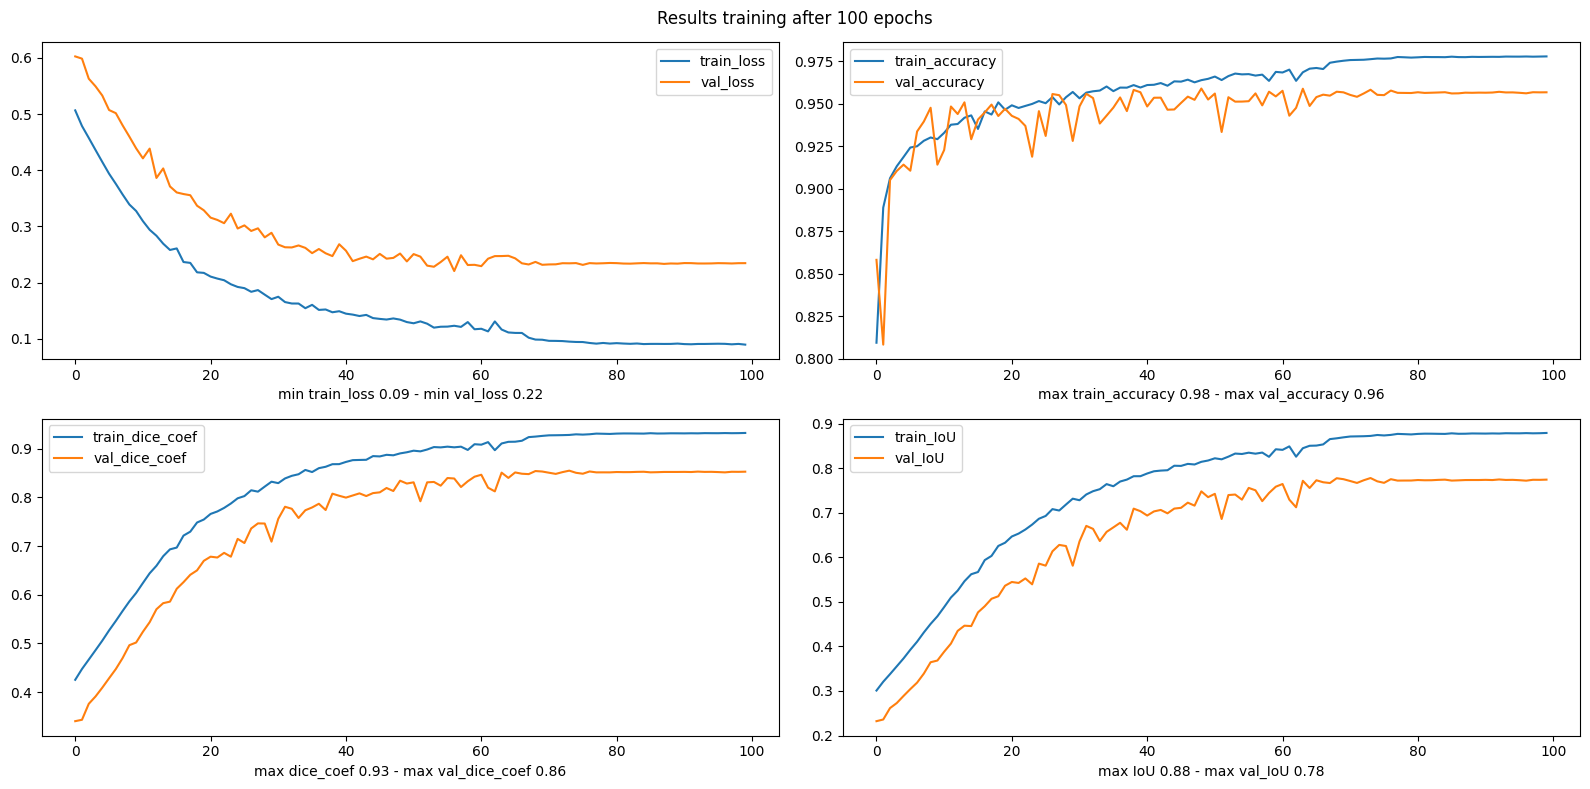

175/175 [==============================] - 171s 975ms/step - loss: 0.0896 - accuracy: 0.9777 - dice_coef: 0.9325 - IoU: 0.8789 - val_loss: 0.2347 - val_accuracy: 0.9567 - val_dice_coef: 0.8529 - val_IoU: 0.7742 - lr: 1.0000e-05


In [ ]:
# train
History = model.fit(X_train, Y_train, validation_split=Validation_split, batch_size=8, epochs=100, callbacks=callbacks)

In [ ]:
results = model.evaluate(X_validating, Y_validating, batch_size=8, callbacks=callbacks)
print("loss : {} ".format(results[0]))
print("acc  : {} ".format(results[1]))
print("dice : {} ".format(results[2]))
print("IoU  : {} ".format(results[3]))

19/19 [==============================] - 14s 743ms/step - loss: 0.2801 - accuracy: 0.9353 - dice_coef: 0.8277 - IoU: 0.7404
loss : 0.2800552546977997 
acc  : 0.9352503418922424 
dice : 0.8276773691177368 
IoU  : 0.7404340505599976 


## Visualize result

In [ ]:
model = Unet()
model.load_weights(save_path)

In [ ]:
preds_test = model.predict(X_test, verbose=1)                         # thực hiện dự đoán trên tập data X_test bằng mô hình Unet
preds_test_t = (preds_test > 0.5).astype(float)                        # chuyển đổi các giá trị dự đoán preds_test thành các nhãn nhị phân: (preds_test > 0.5) trả về 1 mảng Boolean có cùng kích thước với preds_test;
                                                                          # .astype(np.float): chuyển đổi mảng Boolean thành mảng chứa các giá trị 0 và 1 dưới dạng số thực (float)
size_samples = 4
random_list = np.random.randint(len(preds_test_t),size = size_samples)    # tạo mảng random_list có 5 phần tử, mỗi phần tử là 1 số ngẫu nhiên trong khoảng từ 0 đến len()
fg , ax = plt.subplots(size_samples,3,figsize = (16,16))
fg.suptitle("Compare result training set")

for stt,ix in enumerate(random_list):
  ax[stt,0].imshow(X_test[ix]/255.0)
  ax[stt,0].set_xlabel("original image {}".format(ix))
  ax[stt,1].imshow(np.squeeze(Y_test[ix]))
  ax[stt,1].set_xlabel("mask: IoU|Dice")
  ax[stt,2].imshow(np.squeeze(preds_test_t[ix]))
  ax[stt,2].set_xlabel("predict {}|{}".format(np.round(IoU(np.expand_dims(Y_test[ix],axis = 0),np.expand_dims(preds_test_t[ix],axis = 0)),3),
                                              np.round(dice_coef(np.expand_dims(Y_test[ix],axis = 0),np.expand_dims(preds_test_t[ix],axis = 0)),3)))
plt.show()


# Unet++ model

## Define Unet++ model

In [ ]:
def standard_unit(input_tensor, stage, nb_filter, kernel_size=3):    # stage: tạo thứ tự cho các lớp Con2D và Dropout hiển thị trong tóm tắt kiến trúc

  dropout_rate = 0.5
  x = Conv2D(nb_filter, (kernel_size, kernel_size), activation='relu', name='conv'+stage+'_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(learning_rate))(input_tensor)
  x = BatchNormalization()(x)        # chuẩn hóa đầu ra bằng cthuc với mean và variance
  # x = LeakyReLU(alpha = 0.2)(x)
  x = Dropout(dropout_rate, name='dp'+stage+'_1')(x)

  x = Conv2D(nb_filter, (kernel_size, kernel_size), activation='relu', name='conv'+stage+'_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(learning_rate))(x)
  x = BatchNormalization()(x)
  # x = LeakyReLU(alpha = 0.2)(x)
  x = Dropout(dropout_rate, name='dp'+stage+'_2')(x)

  return x

### No deep - supervision

In [ ]:
def Unet_plus_plus(deep_supervision = False):
  # parameter
  nb_filter = [8,16,32,64,128]
  bn_axis = -1

  inputs = Input((IMG_HEIGHT, IMG_WIDTH, NUM_CHANNEL))
  s = tf.keras.layers.Lambda(lambda x: x / 255.0)(inputs)

  conv1_1 = standard_unit(s,'11',nb_filter[0])
  pool1 = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

  conv2_1 = standard_unit(pool1, '21', nb_filter[1])
  pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

  up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
  conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
  conv1_2 = standard_unit(conv1_2, '12',nb_filter[0])

  conv3_1 = standard_unit(pool2, '31', nb_filter[2])
  pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

  up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
  conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
  conv2_2 = standard_unit(conv2_2,'22', nb_filter[1])

  up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
  conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
  conv1_3 = standard_unit(conv1_3,'13',nb_filter[0])

  conv4_1 = standard_unit(pool3,'41', nb_filter[3])
  pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

  up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
  conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
  conv3_2 = standard_unit(conv3_2, '32', nb_filter[2])

  up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
  conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
  conv2_3 = standard_unit(conv2_3, '23', nb_filter[1])

  up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
  conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
  conv1_4 = standard_unit(conv1_4, '14', nb_filter[0])

  conv5_1 = standard_unit(pool4, '51', nb_filter[4])

  up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
  conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
  conv4_2 = standard_unit(conv4_2, '42', nb_filter[3])

  up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
  conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
  conv3_3 = standard_unit(conv3_3, '33', nb_filter[2])

  up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
  conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
  conv2_4 = standard_unit(conv2_4, '24', nb_filter[1])

  up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
  conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
  conv1_5 = standard_unit(conv1_5, '15', nb_filter[0])

  nestnet_output_1 = Conv2D(1, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
  nestnet_output_2 = Conv2D(1, (1, 1), activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
  nestnet_output_3 = Conv2D(1, (1, 1), activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
  nestnet_output_4 = Conv2D(1, (1, 1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)

  if deep_supervision:
      output = average([nestnet_output_1,nestnet_output_2,nestnet_output_3,nestnet_output_4])
      # output = Conv2D(1, (1, 1), activation='sigmoid', name='output', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(output)
      model = Model(inputs, output)
  else:
      model = Model(inputs, nestnet_output_4)
  return model


#### Callbacks

In [ ]:
# callbacks                                       # đảm bảo hiệu quả của quá trình training
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, monitor="train_accuracy"),                                    # dừng quá trình huấn luyện sớm nếu không có sự cải thiện đáng kể trong độ đo accuracy sau 10 epochs
        tf.keras.callbacks.ModelCheckpoint(unet_plus2_path, verbose=2, save_best_only=True),                              # verbose=2 là hiển thị thông báo chi tiết khi lưu trạng thái tốt nhất của mô hình
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001),          # monitor='val_loss': theo dõi val_loss trên tập kiểm tra; Khi hiệu suất không cải thiện sau 10 epoch,
                                                                                                                    # tỷ lệ học sẽ được nhân với factor để giảm; tỷ lệ học giảm đến min_lr, nó sẽ không được giảm nữa
        plot_losses
            ]


#### Compile and train

In [ ]:
# compile
model = Unet_plus_plus()
model.compile(loss=bce_dice_loss,
              optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5,beta_1=0.9, beta_2=0.99, epsilon=1e-05),
              metrics=[dice_coef,IoU,"accuracy"])
model.summary()

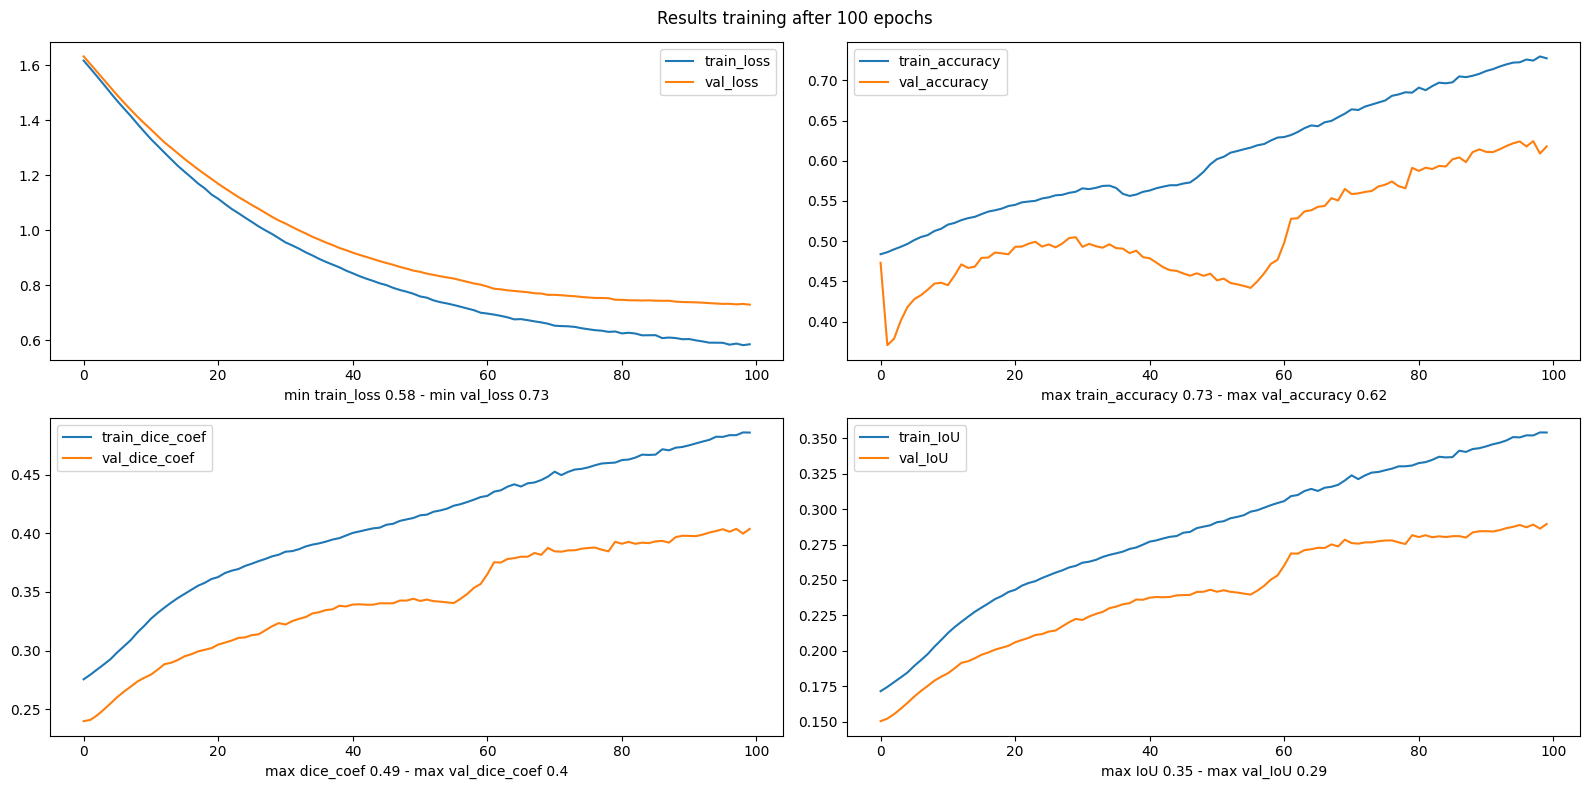

175/175 [==============================] - 24s 138ms/step - loss: 0.5858 - dice_coef: 0.4861 - IoU: 0.3541 - accuracy: 0.7273 - val_loss: 0.7296 - val_dice_coef: 0.4038 - val_IoU: 0.2895 - val_accuracy: 0.6178 - lr: 1.0000e-05


In [ ]:
History = model.fit(X_train, Y_train, validation_split=Validation_split, batch_size=8, epochs=100, callbacks=callbacks)

In [ ]:
results = model.evaluate(X_test, Y_test, batch_size=16, callbacks=callbacks)
print("loss : {} ".format(results[0]))
print("acc  : {} ".format(results[3]))
print("dice : {} ".format(results[1]))
print("IoU  : {} ".format(results[2]))

13/13 [==============================] - 3s 38ms/step - loss: 0.7043 - dice_coef: 0.4054 - IoU: 0.2833 - accuracy: 0.6102
loss : 0.7043241858482361 
acc  : 0.610201358795166 
dice : 0.40544646978378296 
IoU  : 0.2832943797111511 


#### Visualize result

In [ ]:
model = Unet_plus_plus()
model.load_weights(unet_plus2_path)

In [ ]:
preds_test = model.predict(X_test, verbose=1)                         # thực hiện dự đoán trên tập data X_test bằng mô hình Unet
preds_test_t = (preds_test > 0.5).astype(float)                        # chuyển đổi các giá trị dự đoán preds_test thành các nhãn nhị phân: (preds_test > 0.5) trả về 1 mảng Boolean có cùng kích thước với preds_test;
                                                                          # .astype(np.float): chuyển đổi mảng Boolean thành mảng chứa các giá trị 0 và 1 dưới dạng số thực (float)
size_samples = 4
random_list = np.random.randint(len(preds_test_t),size = size_samples)    # tạo mảng random_list có 5 phần tử, mỗi phần tử là 1 số ngẫu nhiên trong khoảng từ 0 đến len()
fg , ax = plt.subplots(size_samples,3,figsize = (16,16))
fg.suptitle("Compare result training set")

for stt,ix in enumerate(random_list):
    ax[stt,0].imshow(X_test[ix]/255.0)
    ax[stt,0].set_xlabel("original image {}".format(ix))
    ax[stt,1].imshow(np.squeeze(Y_test[ix]))
    ax[stt,1].set_xlabel("mask: IoU|Dice")
    ax[stt,2].imshow(np.squeeze(preds_test_t[ix]))
    ax[stt,2].set_xlabel("predict {}|{}".format(np.round(IoU(np.expand_dims(Y_test[ix],axis = 0),np.expand_dims(preds_test_t[ix],axis = 0)),3),
                                                np.round(dice_coef(np.expand_dims(Y_test[ix],axis = 0),np.expand_dims(preds_test_t[ix],axis = 0)),3)))
plt.show()

### Use deep - supervision

#### Callbacks

In [ ]:
# callbacks
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, monitor="accuracy"),
        tf.keras.callbacks.ModelCheckpoint(unet_plus2_path1, verbose=2, save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_IoU', factor=0.1, patience=10, min_lr=1e-5),
        plot_losses
            ]

#### Compile and train

In [ ]:
# train
model = Unet_plus_plus(deep_supervision = True)
model.compile(loss=bce_dice_loss,
              optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5,beta_1=0.9, beta_2=0.999, epsilon=1e-07),
              metrics=[dice_coef,IoU,"accuracy"])

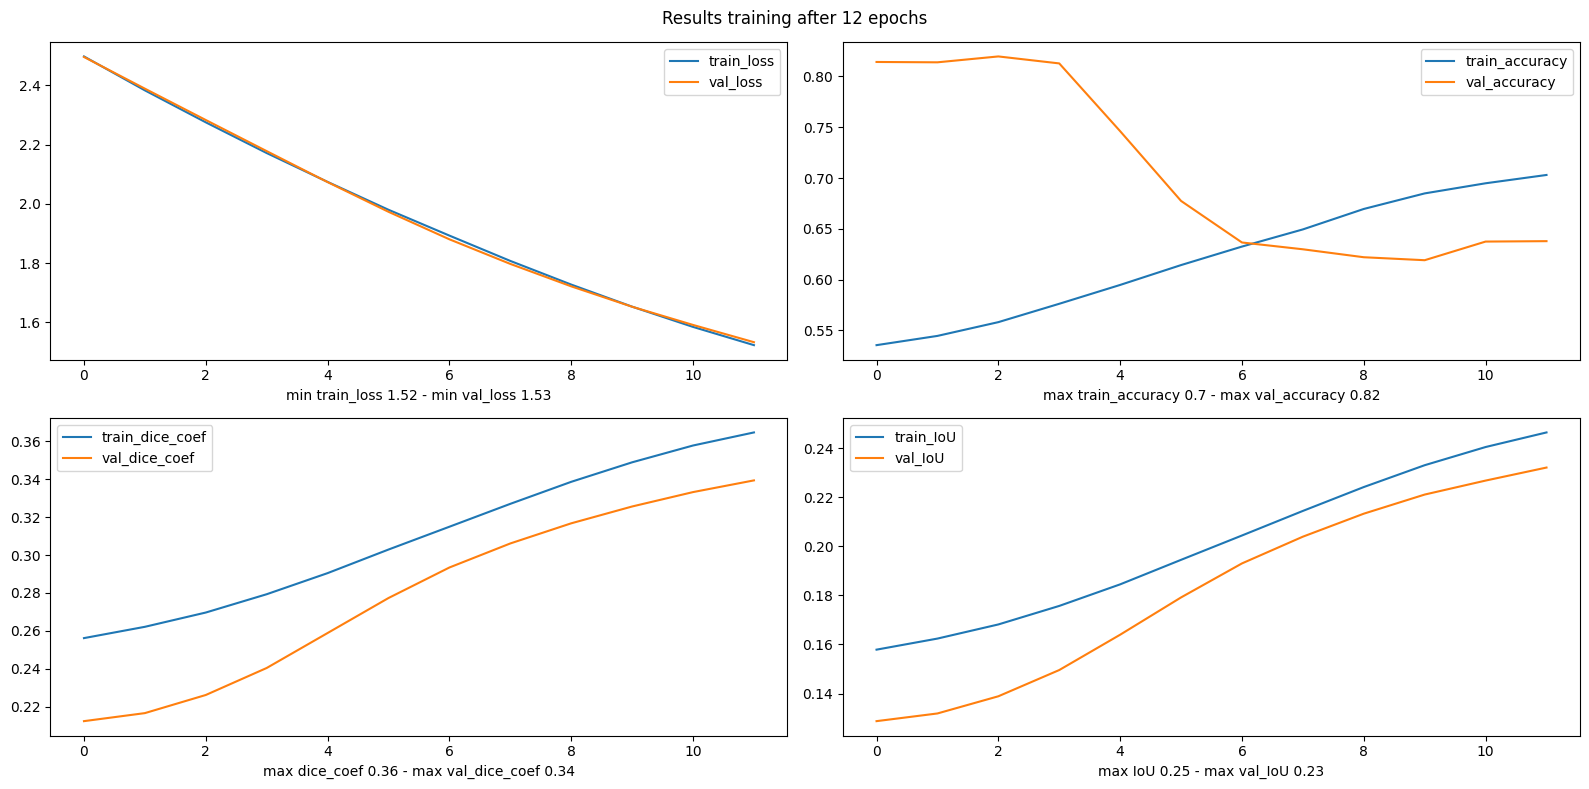

250/250 [==============================] - 2146s 9s/step - loss: 1.5233 - dice_coef: 0.3648 - IoU: 0.2464 - accuracy: 0.7030 - val_loss: 1.5333 - val_dice_coef: 0.3394 - val_IoU: 0.2321 - val_accuracy: 0.6379 - lr: 1.0000e-05
Epoch 13/100
137/250 [===============>..............] - ETA: 15:47 - loss: 1.4837 - dice_coef: 0.3676 - IoU: 0.2481 - accuracy: 0.7047

In [ ]:
History = model.fit(X_train, Y_train, validation_data = (X_validating, Y_validating), batch_size=8, epochs=100, callbacks=callbacks)

In [ ]:
results = model.evaluate(X_test, Y_test, batch_size=8, callbacks=callbacks)
print("loss : {} ".format(results[0]))
print("acc  : {} ".format(results[3]))
print("dice : {} ".format(results[1]))
print("IoU  : {} ".format(results[2]))

#### Visualize result

In [ ]:
model = Unet_plus_plus(deep_supervision = True)
model.load_weights(unet_plus2_path1)

In [ ]:
preds_test = model.predict(X_test, verbose=1)                         # thực hiện dự đoán trên tập data X_test bằng mô hình Unet
preds_test_t = (preds_test > 0.5).astype(float)                        # chuyển đổi các giá trị dự đoán preds_test thành các nhãn nhị phân: (preds_test > 0.5) trả về 1 mảng Boolean có cùng kích thước với preds_test;
                                                                          # .astype(np.float): chuyển đổi mảng Boolean thành mảng chứa các giá trị 0 và 1 dưới dạng số thực (float)
size_samples = 4
random_list = np.random.randint(len(preds_test_t),size = size_samples)    # tạo mảng random_list có 5 phần tử, mỗi phần tử là 1 số ngẫu nhiên trong khoảng từ 0 đến len()
fg , ax = plt.subplots(size_samples,3,figsize = (16,16))
fg.suptitle("Compare result training set")

for stt,ix in enumerate(random_list):
  ax[stt,0].imshow(X_test[ix]/255.0)
  ax[stt,0].set_xlabel("original image {}".format(ix))
  ax[stt,1].imshow(np.squeeze(Y_test[ix]))
  ax[stt,1].set_xlabel("mask: IoU|Dice")
  ax[stt,2].imshow(np.squeeze(preds_test_t[ix]))
  ax[stt,2].set_xlabel("predict {}|{}".format(np.round(IoU(np.expand_dims(Y_test[ix],axis = 0),np.expand_dims(preds_test_t[ix],axis = 0)),3),
                                              np.round(dice_coef(np.expand_dims(Y_test[ix],axis = 0),np.expand_dims(preds_test_t[ix],axis = 0)),3)))
plt.show()

## Option backbone of Unet++

In [ ]:
def standard_unit(input_tensor, stage, nb_filter, kernel_size=3):                 # stage: tạo thứ tự cho các lớp Con2D và Dropout hiển thị trong tóm tắt kiến trúc

    dropout_rate = 0.5
    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation='relu', name='conv'+stage+'_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(learning_rate))(input_tensor)
    x = BatchNormalization()(x)                                                     # chuẩn hóa đầu ra bằng cthuc với mean và variance
    # x = LeakyReLU(alpha = 0.2)(x)
    x = Dropout(dropout_rate, name='dp'+stage+'_1')(x)

    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation='relu', name='conv'+stage+'_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(learning_rate))(x)
    x = BatchNormalization()(x)
    # x = LeakyReLU(alpha = 0.2)(x)
    x = Dropout(dropout_rate, name='dp'+stage+'_2')(x)

  return x

In [ ]:
def get_skip(input_tensor,backbone):
    skip_connection = []

    if backbone == "VGG19":
      base_model = VGG19(include_top=False, weights='imagenet', input_tensor=input_tensor)
      names = ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv4","block5_conv4"]

    if backbone == "DenseNet201":
      base_model = DenseNet201(include_top=False, weights='imagenet', input_tensor=input_tensor)
      # names = ["input_2","conv1/relu","pool2_conv","pool3_conv","pool4_conv"]
      layer_names=[layer.name for layer in base_model.layers]
      names = []
      for i in [1,4,51,139,479]:
        names.append(layer_names[i])

    for name in names:
      skip_connection.append(base_model.get_layer(name).output)

  return skip_connection


In [ ]:
def build_model(backbone,deep_supervision = False):
    # parameter
    nb_filter = [16,32,64,128,256]
    bn_axis = -1


    inputs = Input((IMG_HEIGHT, IMG_WIDTH, NUM_CHANNEL))
    s = tf.keras.layers.Lambda(lambda x: x / 255.0)(inputs)
    skip_connection = get_skip(s,backbone)

    conv1_1 = skip_connection[0]

    conv2_1 = skip_connection[1]


    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = standard_unit(conv1_2, '12',nb_filter[0])

    conv3_1 = skip_connection[2]


    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = standard_unit(conv2_2,'22', nb_filter[1])

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = standard_unit(conv1_3,'13',nb_filter[0])

    conv4_1 = skip_connection[3]


    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = standard_unit(conv3_2, '32', nb_filter[2])

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = standard_unit(conv2_3, '23', nb_filter[1])

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = standard_unit(conv1_4, '14', nb_filter[0])

    conv5_1 = skip_connection[4]

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = standard_unit(conv4_2, '42', nb_filter[3])

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = standard_unit(conv3_3, '33', nb_filter[2])

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = standard_unit(conv2_4, '24', nb_filter[1])

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = standard_unit(conv1_5, '15', nb_filter[0])

    nestnet_output_1 = Conv2D(1, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
    nestnet_output_2 = Conv2D(1, (1, 1), activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
    nestnet_output_3 = Conv2D(1, (1, 1), activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
    nestnet_output_4 = Conv2D(1, (1, 1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)

    if deep_supervision:
      output = average([nestnet_output_1,nestnet_output_2,nestnet_output_3,nestnet_output_4])
      # output = Conv2D(1, (1, 1), activation='sigmoid', name='output', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(output)
      model = Model(inputs, output)
    else:
      model = Model(inputs, nestnet_output_4)

    optimizer = tf.keras.optimizers.Adam(learning_rate)                                            # lớp tối ưu hóa Adam
    model.compile(loss=bce_dice_loss, optimizer=optimizer, metrics=[dice_coef,IoU,"accuracy"])     # cấu hình quá trình huấn luyện
    return model



#### VGG19

In [ ]:
# callbacks
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=50, monitor="accuracy"),
        tf.keras.callbacks.ModelCheckpoint(unet_plus2_path2, verbose=2, save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_IoU', factor=0.5, patience=10, min_lr=1e-5),
        plot_losses,
            ]

In [ ]:
model = build_model("VGG19")
model.summary()

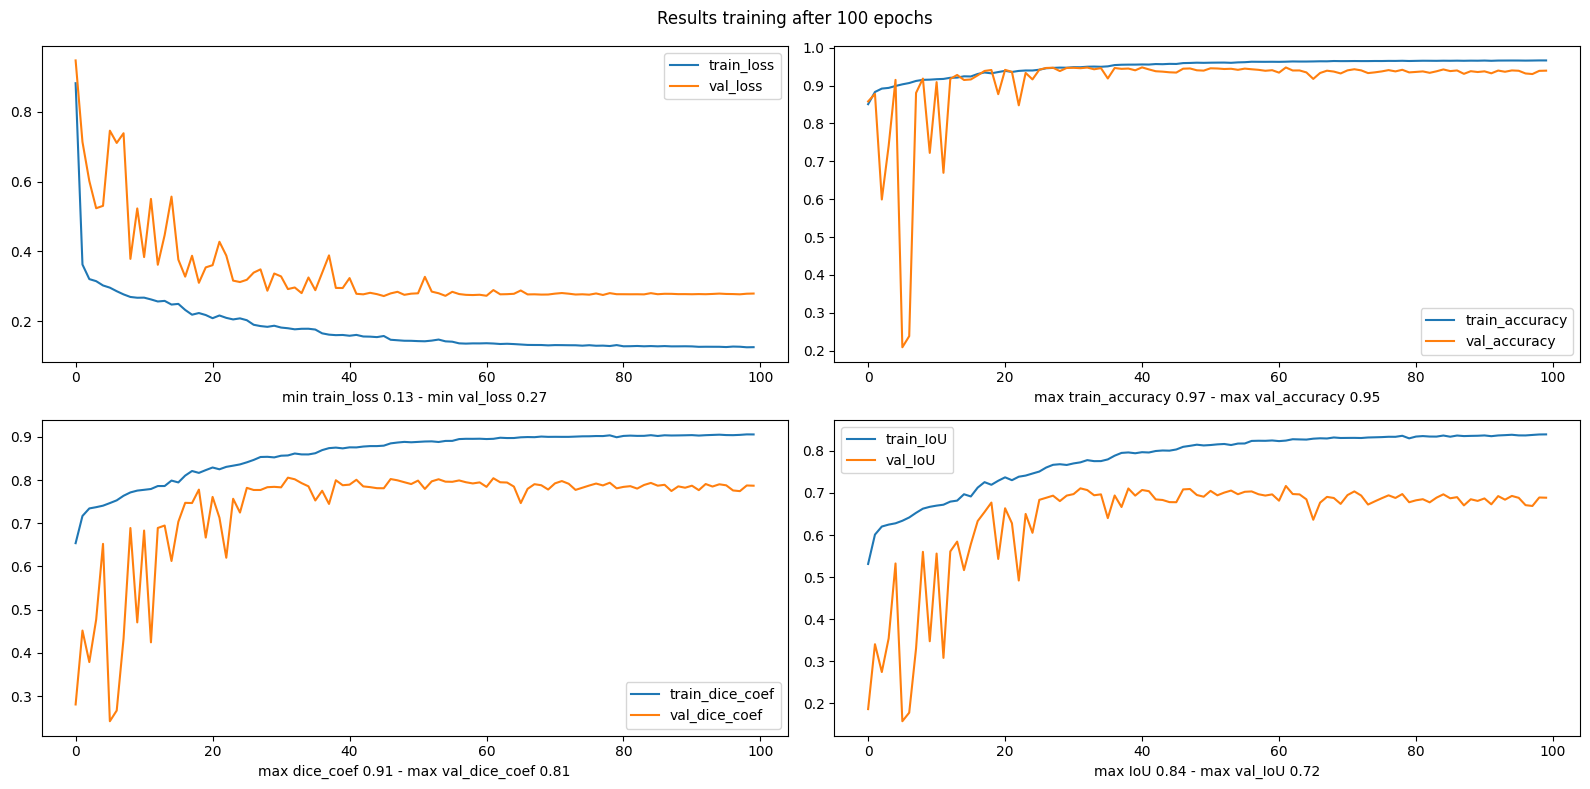

175/175 [==============================] - 159s 908ms/step - loss: 0.1256 - dice_coef: 0.9056 - IoU: 0.8392 - accuracy: 0.9663 - val_loss: 0.2793 - val_dice_coef: 0.7869 - val_IoU: 0.6887 - val_accuracy: 0.9393 - lr: 1.0000e-05


In [ ]:
# train
History = model.fit(X_train, Y_train, validation_split=Validation_split, batch_size=8, epochs=100, callbacks=callbacks)

In [ ]:
results = model.evaluate(X_test, Y_test, batch_size=8, callbacks=callbacks)
print("loss : {} ".format(results[0]))
print("acc  : {} ".format(results[3]))
print("dice : {} ".format(results[1]))
print("IoU  : {} ".format(results[2]))

 6/25 [======>.......................] - ETA: 3s - loss: 0.6125 - dice_coef: 0.5698 - IoU: 0.4523 - accuracy: 0.7881

25/25 [==============================] - 5s 189ms/step - loss: 0.4723 - dice_coef: 0.6917 - IoU: 0.5807 - accuracy: 0.8746
loss : 0.4723207950592041 
acc  : 0.8745582103729248 
dice : 0.6916564106941223 
IoU  : 0.5806952714920044 


##### Visualize result

In [ ]:
model = build_model("VGG19")
model.load_weights(unet_plus2_path2)

7/7 [==============================] - 4s 620ms/step


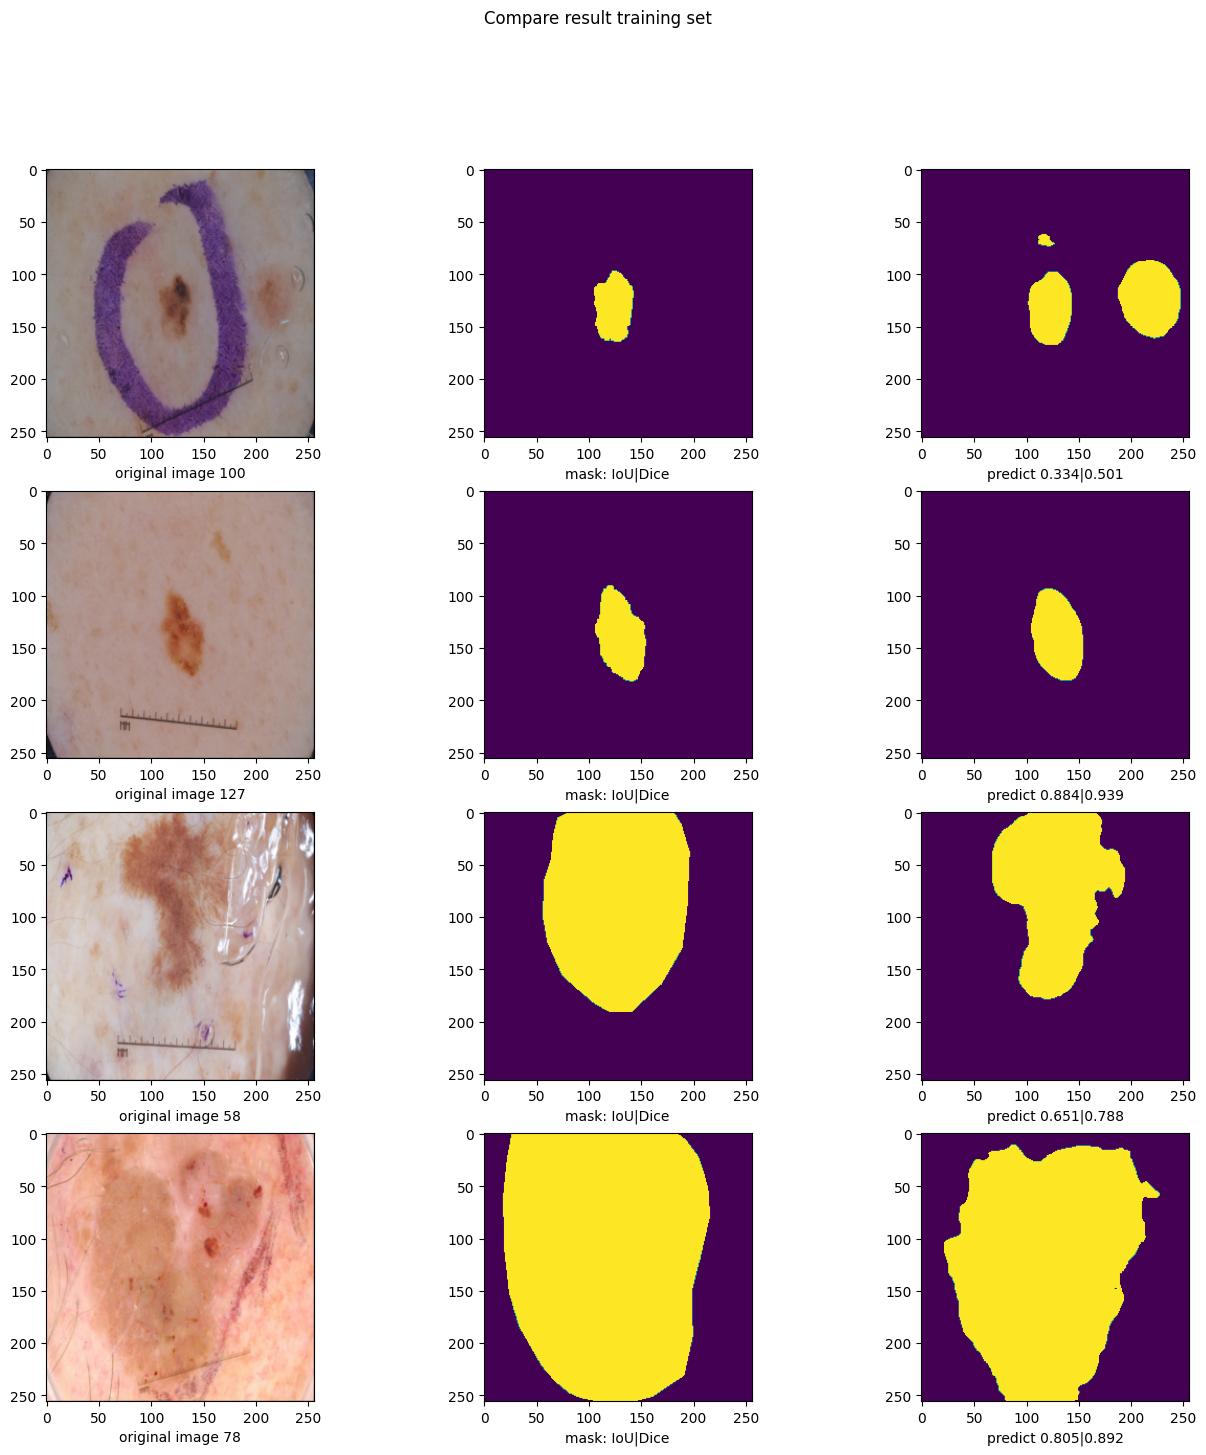

In [ ]:
preds_test = model.predict(X_test, verbose=1)                         # thực hiện dự đoán trên tập data X_test bằng mô hình Unet
preds_test_t = (preds_test > 0.5).astype(float)                        # chuyển đổi các giá trị dự đoán preds_test thành các nhãn nhị phân: (preds_test > 0.5) trả về 1 mảng Boolean có cùng kích thước với preds_test;
                                                                          # .astype(np.float): chuyển đổi mảng Boolean thành mảng chứa các giá trị 0 và 1 dưới dạng số thực (float)
size_samples = 4
random_list = np.random.randint(len(preds_test_t),size = size_samples)    # tạo mảng random_list có 5 phần tử, mỗi phần tử là 1 số ngẫu nhiên trong khoảng từ 0 đến len()
fg , ax = plt.subplots(size_samples,3,figsize = (16,16))
fg.suptitle("Compare result training set")

for stt,ix in enumerate(random_list):
  ax[stt,0].imshow(X_test[ix]/255.0)
  ax[stt,0].set_xlabel("original image {}".format(ix))
  ax[stt,1].imshow(np.squeeze(Y_test[ix]))
  ax[stt,1].set_xlabel("mask: IoU|Dice")
  ax[stt,2].imshow(np.squeeze(preds_test_t[ix]))
  ax[stt,2].set_xlabel("predict {}|{}".format(np.round(IoU(np.expand_dims(Y_test[ix],axis = 0),np.expand_dims(preds_test_t[ix],axis = 0)),3),
                                              np.round(dice_coef(np.expand_dims(Y_test[ix],axis = 0),np.expand_dims(preds_test_t[ix],axis = 0)),3)))
plt.show()

#### DenseNet

In [ ]:
# callbacks
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=30, monitor="accuracy"),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_IoU', factor=0.5, patience=10, min_lr=1e-5),
        plot_losses,
        # tf.keras.callbacks.LearningRateScheduler(schedule, verbose=2)
            ]

In [ ]:
model = build_model("DenseNet201")
model.summary()

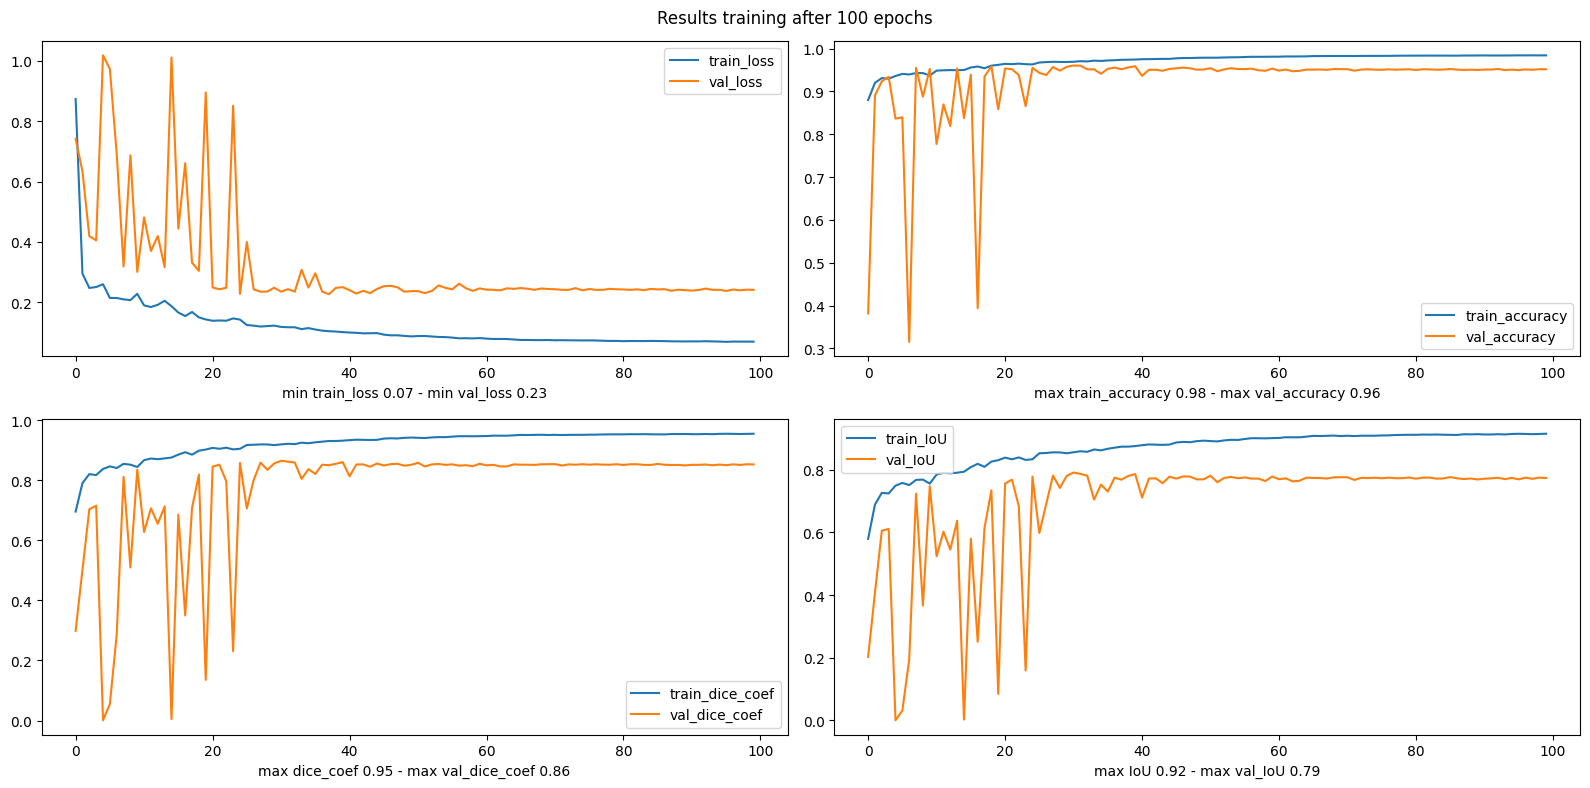

175/175 [==============================] - 151s 863ms/step - loss: 0.0690 - dice_coef: 0.9549 - IoU: 0.9150 - accuracy: 0.9841 - val_loss: 0.2407 - val_dice_coef: 0.8527 - val_IoU: 0.7737 - val_accuracy: 0.9517 - lr: 1.0000e-05


In [ ]:
History = model.fit(X_train, Y_train, validation_split=Validation_split, batch_size=8, epochs=100, callbacks=callbacks)

In [ ]:
results = model.evaluate(X_test, Y_test, batch_size=8, callbacks=callbacks)
print("loss : {} ".format(results[0]))
print("acc  : {} ".format(results[3]))
print("dice : {} ".format(results[1]))
print("IoU  : {} ".format(results[2]))

 6/25 [======>.......................] - ETA: 2s - loss: 0.4243 - dice_coef: 0.7360 - IoU: 0.6180 - accuracy: 0.8631

25/25 [==============================] - 4s 156ms/step - loss: 0.4111 - dice_coef: 0.7632 - IoU: 0.6612 - accuracy: 0.8965
loss : 0.41108837723731995 
acc  : 0.896461009979248 
dice : 0.7632129192352295 
IoU  : 0.6611555218696594 


##### Visualize result

In [ ]:
preds_test = model.predict(X_test, verbose=1)                         # thực hiện dự đoán trên tập data X_test bằng mô hình Unet
preds_test_t = (preds_test > 0.5).astype(float)                        # chuyển đổi các giá trị dự đoán preds_test thành các nhãn nhị phân: (preds_test > 0.5) trả về 1 mảng Boolean có cùng kích thước với preds_test;
                                                                          # .astype(np.float): chuyển đổi mảng Boolean thành mảng chứa các giá trị 0 và 1 dưới dạng số thực (float)
size_samples = 4
random_list = np.random.randint(len(preds_test_t),size = size_samples)    # tạo mảng random_list có 5 phần tử, mỗi phần tử là 1 số ngẫu nhiên trong khoảng từ 0 đến len()
fg , ax = plt.subplots(size_samples,3,figsize = (16,16))
fg.suptitle("Compare result training set")

for stt,ix in enumerate(random_list):
  ax[stt,0].imshow(X_test[ix]/255.0)
  ax[stt,0].set_xlabel("original image {}".format(ix))
  ax[stt,1].imshow(np.squeeze(Y_test[ix]))
  ax[stt,1].set_xlabel("mask: IoU|Dice")
  ax[stt,2].imshow(np.squeeze(preds_test_t[ix]))
  ax[stt,2].set_xlabel("predict {}|{}".format(np.round(IoU(np.expand_dims(Y_test[ix],axis = 0),np.expand_dims(preds_test_t[ix],axis = 0)),3),
                                              np.round(dice_coef(np.expand_dims(Y_test[ix],axis = 0),np.expand_dims(preds_test_t[ix],axis = 0)),3)))
plt.show()